In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout


In [2]:
# Load the data
data = pd.read_csv('stockmarkettata.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Convert date column to datetime
data.sort_values('Date', inplace=True)  # Ensure data is sorted by date
data.set_index('Date', inplace=True)  # Set date as index for easier analysis

# Display the first few rows of the data
data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,43.5,43.5,43.5,43.5,16.114737,0
2000-01-04,43.5,43.5,43.5,43.5,16.114737,0
2000-01-05,43.5,43.5,43.5,43.5,16.114737,0
2000-01-06,43.5,43.5,43.5,43.5,16.114737,0
2000-01-07,43.5,43.5,43.5,43.5,16.114737,0


In [3]:
# Check for missing values
data.isnull().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Drop rows with missing values
data.dropna(inplace=True)


In [7]:
# Re-check for missing values
print(data.isnull().sum().sum())  # Should output 0 if all missing values are handled


0


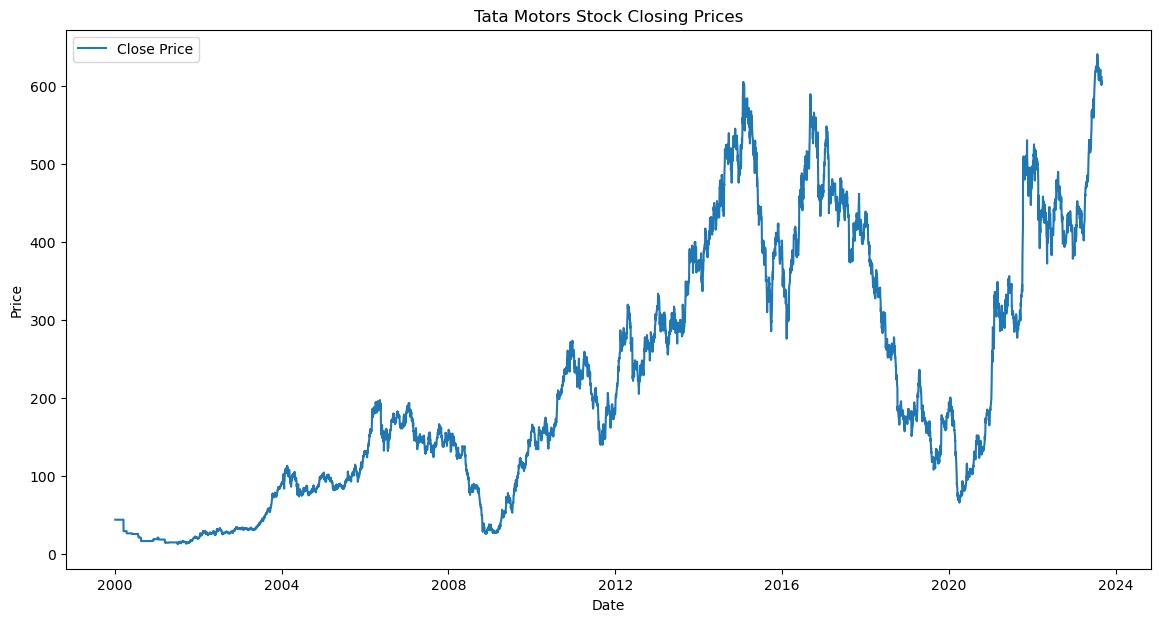

In [8]:
# Plot the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('Tata Motors Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


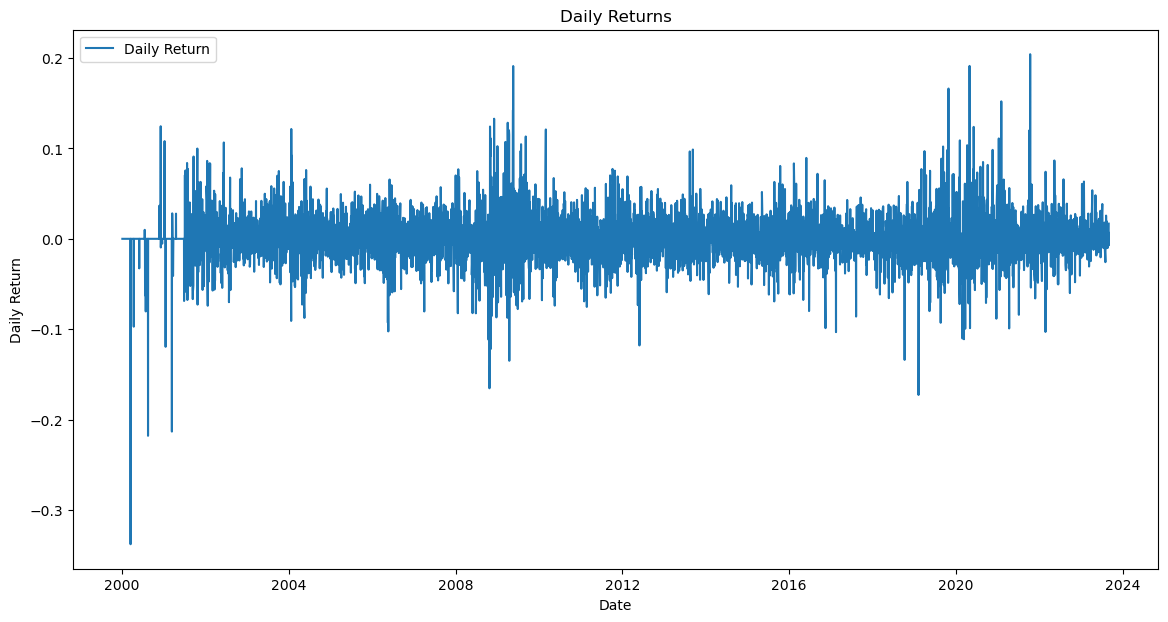

In [9]:
# Calculate and plot daily returns
data['Daily Return'] = data['Close'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(data['Daily Return'], label='Daily Return')
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


In [10]:
# Scale the closing prices for better performance during training
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled Close'] = scaler.fit_transform(data[['Close']])

# Display the first few rows with the scaled close prices
data[['Close', 'Scaled Close']].head()


,Close,Scaled Close
Date,,
2000-01-03,43.5,0.050036
2000-01-04,43.5,0.050036
2000-01-05,43.5,0.050036
2000-01-06,43.5,0.050036
2000-01-07,43.5,0.050036


In [11]:
# Set the lookback period
lookback = 60

# Prepare the sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare training and testing data
scaled_data = data['Scaled Close'].values.reshape(-1, 1)
X, y = create_sequences(scaled_data, lookback)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for the CNN-LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [12]:
# Define the CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dense(1)  # Predicting one value (stock price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 58, 50)            23000     
                                                                 
 dropout (Dropout)           (None, 58, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 43507 (169.95 KB)
Trainable params: 43507 (169.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
146/146 [==============================] - 10s 36ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 2/50
146/146 [==============================] - 4s 30ms/step - loss: 7.0417e-04 - val_loss: 0.0012
Epoch 3/50
146/146 [==============================] - 4s 31ms/step - loss: 6.6310e-04 - val_loss: 0.0011
Epoch 4/50
146/146 [==============================] - 4s 29ms/step - loss: 5.6515e-04 - val_loss: 0.0010
Epoch 5/50
146/146 [==============================] - 4s 27ms/step - loss: 5.3350e-04 - val_loss: 0.0011
Epoch 6/50
146/146 [==============================] - 5s 36ms/step - loss: 4.9355e-04 - val_loss: 0.0011
Epoch 7/50
146/146 [==============================] - 8s 52ms/step - loss: 5.2815e-04 - val_loss: 7.2118e-04
Epoch 8/50
146/146 [==============================] - 5s 31ms/step - loss: 4.4326e-04 - val_loss: 8.8610e-04
Epoch 9/50
146/146 [==============================] - 4s 30ms/step - loss: 4.4883e-04 - val_loss: 6.7326e-04
Epoch 10/50
146/146 [=========================

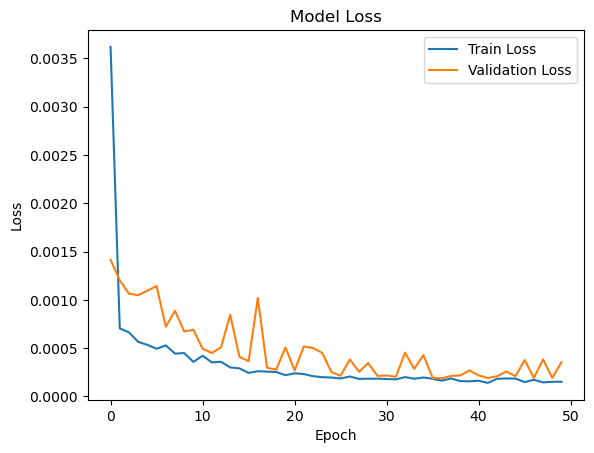

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


37/37 [==============================] - 1s 15ms/step


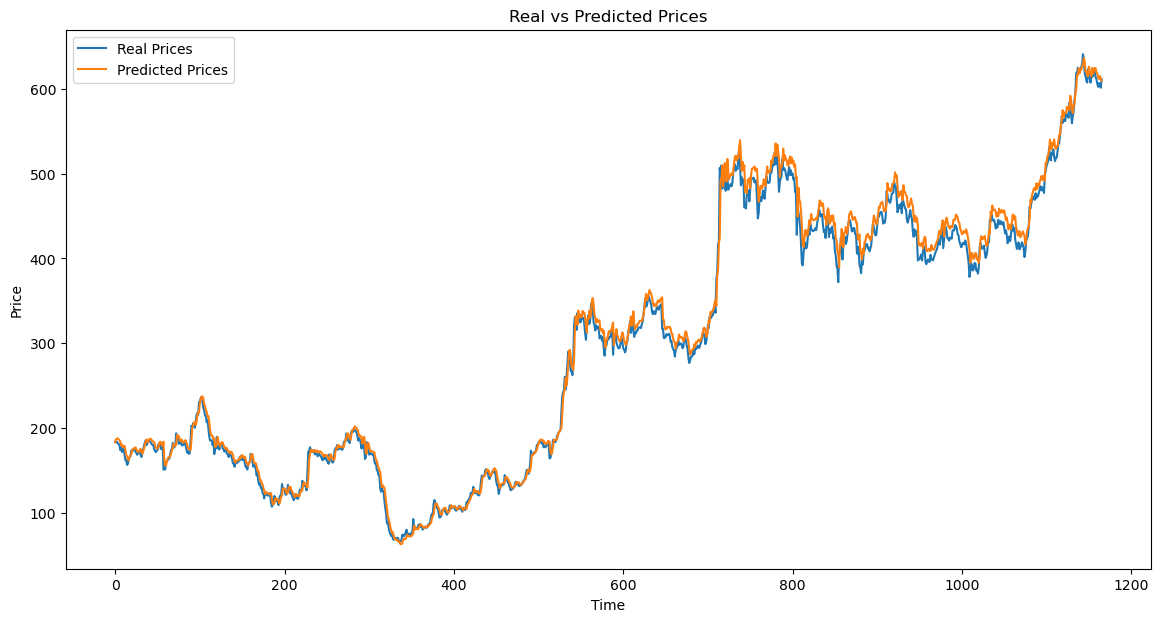

In [25]:
# Predict on test data
predicted_scaled = model.predict(X_test)

# Inverse scaling to get the original scale
predicted_prices = scaler.inverse_transform(predicted_scaled)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predicted vs. real prices
plt.figure(figsize=(14, 7))
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.title('Real vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


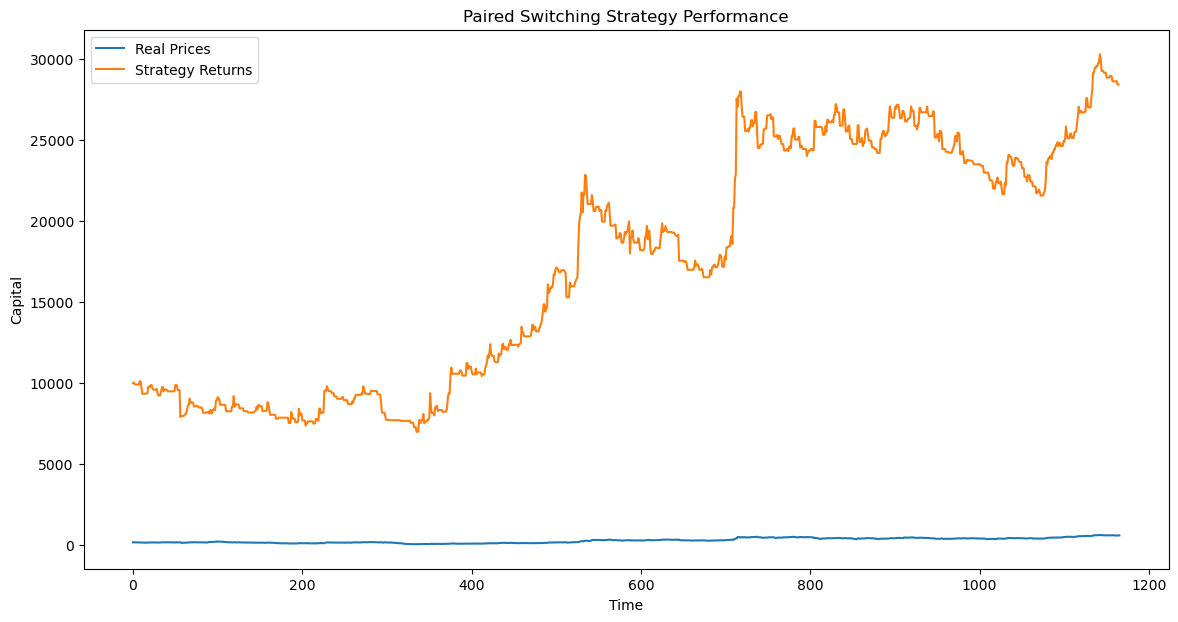

In [15]:
# Paired Switching Strategy Implementation
def paired_switching_strategy(predictions, real_prices, initial_investment=10000):
    capital = initial_investment
    position = 0  # No position initially
    returns = []

    for i in range(1, len(predictions)):
        if predictions[i] > predictions[i - 1]:  # Buy signal
            if position == 0:  # Only buy if no position
                position = capital / real_prices[i]
                capital = 0
        elif predictions[i] < predictions[i - 1]:  # Sell signal
            if position > 0:  # Only sell if holding stock
                capital = position * real_prices[i]
                position = 0
        returns.append(capital + (position * real_prices[i] if position > 0 else 0))

    return returns

# Calculate returns using the strategy
returns = paired_switching_strategy(predicted_prices.flatten(), real_prices.flatten())

# Plot strategy returns
plt.figure(figsize=(14, 7))
plt.plot(real_prices, label="Real Prices")
plt.plot(returns, label="Strategy Returns")
plt.legend()
plt.title('Paired Switching Strategy Performance')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.show()


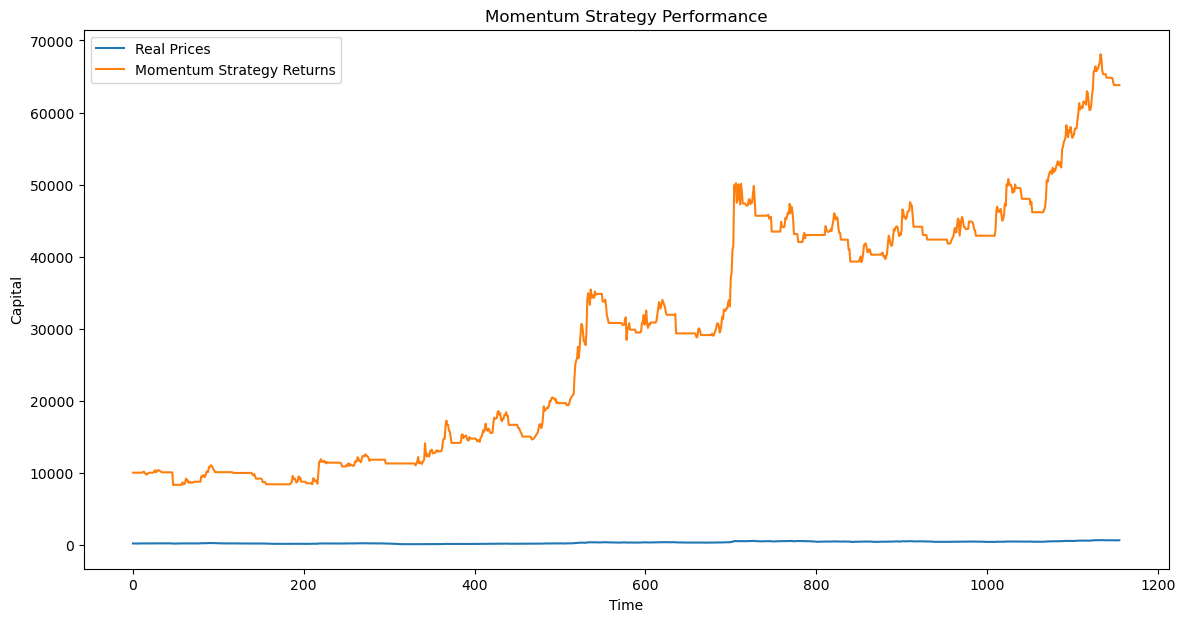

In [16]:
# Momentum Strategy Implementation
def momentum_strategy(real_prices, window=10, initial_investment=10000):
    capital = initial_investment
    position = 0
    returns = []

    for i in range(window, len(real_prices)):
        momentum = (real_prices[i] - real_prices[i - window]) / real_prices[i - window]

        if momentum > 0 and position == 0:  # Buy if upward momentum and no position
            position = capital / real_prices[i]
            capital = 0
        elif momentum < 0 and position > 0:  # Sell if downward momentum and holding stock
            capital = position * real_prices[i]
            position = 0

        returns.append(capital + (position * real_prices[i] if position > 0 else 0))

    return returns

# Calculate returns using momentum strategy
momentum_returns = momentum_strategy(real_prices.flatten())

# Plot momentum strategy returns
plt.figure(figsize=(14, 7))
plt.plot(real_prices[10:], label="Real Prices")
plt.plot(momentum_returns, label="Momentum Strategy Returns")
plt.legend()
plt.title('Momentum Strategy Performance')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.show()


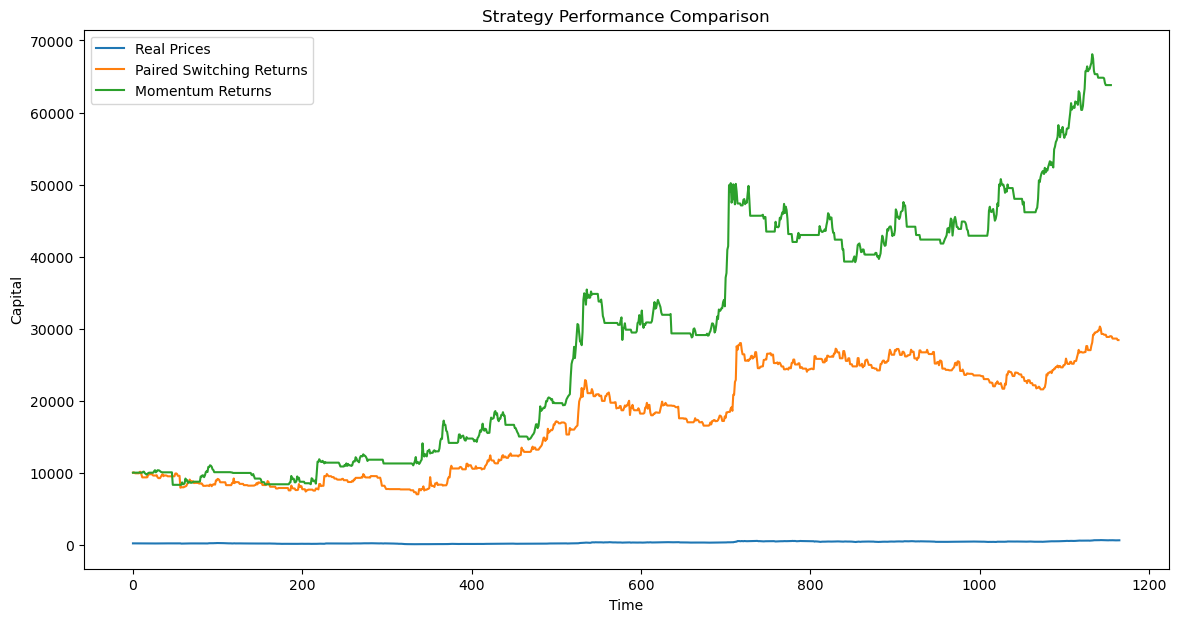

In [17]:
# Final comparison of strategies
plt.figure(figsize=(14, 7))
plt.plot(real_prices, label="Real Prices")
plt.plot(returns, label="Paired Switching Returns")
plt.plot(momentum_returns, label="Momentum Returns")
plt.legend()
plt.title('Strategy Performance Comparison')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.show()


In [19]:
# Paired Switching Strategy
initial_balance = 100000  # Starting with 100,000 INR
balance = initial_balance
stock_units = 0  # Initially, we don't hold any stocks
holding_stock = False  # Tracking if we are holding stock or cash

for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > predicted_prices[i - 1]:  # Predicted price increase
        if not holding_stock:  # Buy stock
            stock_units = balance / real_prices[i]  # Buy as many stocks as possible
            balance = 0  # Cash is now all invested in stock
            holding_stock = True
    elif predicted_prices[i] < predicted_prices[i - 1]:  # Predicted price decrease
        if holding_stock:  # Sell stock
            balance = stock_units * real_prices[i]  # Sell all stock units at current price
            stock_units = 0
            holding_stock = False

# Calculate final balance
if holding_stock:
    balance += stock_units * real_prices[-1]  # Sell remaining stock at last price

# Ensure balance is a scalar value, not an array
balance = balance.item() if isinstance(balance, np.ndarray) else balance

# Calculate and display returns
paired_switching_return = (balance - initial_balance) / initial_balance * 100
print(f"Final balance with Paired Switching Strategy: {balance:.2f} INR")
print(f"Total return with Paired Switching Strategy: {paired_switching_return:.2f}%")


Final balance with Paired Switching Strategy: 284065.37 INR
Total return with Paired Switching Strategy: 184.07%


In [21]:
# Momentum Strategy
momentum_window = 3  # Define the look-back period for momentum
balance = initial_balance
stock_units = 0
holding_stock = False

for i in range(momentum_window, len(predicted_prices)):
    # Calculate momentum: is the average of past 'momentum_window' predictions increasing or decreasing?
    recent_trend = np.mean(predicted_prices[i-momentum_window:i])
    
    if predicted_prices[i] > recent_trend:  # Uptrend (Buy signal)
        if not holding_stock:  # Buy stock
            stock_units = balance / real_prices[i]
            balance = 0
            holding_stock = True
    elif predicted_prices[i] < recent_trend:  # Downtrend (Sell signal)
        if holding_stock:  # Sell stock
            balance = stock_units * real_prices[i]
            stock_units = 0
            holding_stock = False

# Calculate final balance
if holding_stock:
    balance += stock_units * real_prices[-1]

# Ensure balance is a scalar value, not an array
balance = balance.item() if isinstance(balance, np.ndarray) else balance

momentum_return = (balance - initial_balance) / initial_balance * 100
print(f"Final balance with Momentum Strategy: {balance:.2f} INR")
print(f"Total return with Momentum Strategy: {momentum_return:.2f}%")


Final balance with Momentum Strategy: 153839.50 INR
Total return with Momentum Strategy: 53.84%


In [23]:
import numpy as np

# Initialize parameters
initial_balance = 100000  # INR
paired_switching_returns = []
momentum_returns = []
daily_returns_paired = []
daily_returns_momentum = []

# Paired Switching Strategy
balance = initial_balance
stock_units = 0
holding_stock = False

for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > predicted_prices[i - 1]:  # Predicted price increase
        if not holding_stock:  # Buy stock
            stock_units = balance / real_prices[i]
            balance = 0
            holding_stock = True
    elif predicted_prices[i] < predicted_prices[i - 1]:  # Predicted price decrease
        if holding_stock:  # Sell stock
            balance = stock_units * real_prices[i]
            stock_units = 0
            holding_stock = False

    # Track daily balance for volatility and drawdown calculations
    daily_balance = balance + (stock_units * real_prices[i] if holding_stock else 0)
    daily_returns_paired.append(daily_balance)

if holding_stock:
    balance += stock_units * real_prices[-1]
# Ensure balance is a scalar value, not an array
balance = balance.item() if isinstance(balance, np.ndarray) else balance
paired_switching_return = (balance - initial_balance) / initial_balance * 100

# Momentum Strategy
balance = initial_balance
stock_units = 0
holding_stock = False
momentum_window = 3

for i in range(momentum_window, len(predicted_prices)):
    recent_trend = np.mean(predicted_prices[i - momentum_window:i])
    
    if predicted_prices[i] > recent_trend:  # Buy signal
        if not holding_stock:
            stock_units = balance / real_prices[i]
            balance = 0
            holding_stock = True
    elif predicted_prices[i] < recent_trend:  # Sell signal
        if holding_stock:
            balance = stock_units * real_prices[i]
            stock_units = 0
            holding_stock = False
    
    daily_balance = balance + (stock_units * real_prices[i] if holding_stock else 0)
    daily_returns_momentum.append(daily_balance)

if holding_stock:
    balance += stock_units * real_prices[-1]
# Ensure balance is a scalar value, not an array
balance = balance.item() if isinstance(balance, np.ndarray) else balance
momentum_return = (balance - initial_balance) / initial_balance * 100

# Calculate volatility (standard deviation of returns)
volatility_paired = np.std(daily_returns_paired)
volatility_momentum = np.std(daily_returns_momentum)

# Calculate maximum drawdown
drawdown_paired = np.min(daily_returns_paired) / initial_balance - 1
drawdown_momentum = np.min(daily_returns_momentum) / initial_balance - 1

# Calculate Sharpe Ratio (using daily returns and a risk-free rate of 0)
sharpe_ratio_paired = (paired_switching_return / 100) / volatility_paired if volatility_paired != 0 else 0
sharpe_ratio_momentum = (momentum_return / 100) / volatility_momentum if volatility_momentum != 0 else 0

# Display results
print("Paired Switching Strategy:")
print(f"Total Return: {paired_switching_return:.2f}%")
print(f"Volatility: {volatility_paired:.2f}")
print(f"Max Drawdown: {drawdown_paired:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio_paired:.2f}")

print("\nMomentum Strategy:")
print(f"Total Return: {momentum_return:.2f}%")
print(f"Volatility: {volatility_momentum:.2f}")
print(f"Max Drawdown: {drawdown_momentum:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio_momentum:.2f}")


Paired Switching Strategy:
Total Return: 184.07%
Volatility: 73633.58
Max Drawdown: -0.30
Sharpe Ratio: 0.00

Momentum Strategy:
Total Return: 53.84%
Volatility: 25584.50
Max Drawdown: -0.27
Sharpe Ratio: 0.00
